
![delensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - full sky
In this notebook, you perfrom QE and iterative lensing reconstruction for a single simulation, and for the full sky.
The simulations are created upon runtime inclusive of isotropic white noise and without foregrounds, using a built-in CMB-simulations module.
At the end of this tutorial, you will plot the lensing potential estimates and obtain delensed power spectra to calculate the residual lensing amplitude.

All parameters are set via a configuration file [here](https://github.com/NextGenCMB/delensalot/blob/main/notebooks/examples/conf_mwe_fullsky.py), and you can freely change the parameters to your liking.
If not set, attributes default to the 'P_FS_CMBS4'-default configuration 'DL_DEFAULT_CMBS4_FS_P' [here](https://github.com/NextGenCMB/delensalot/blob/simgenjob/delensalot/lerepi/core/metamodel/__init__.py).

The configuration file consists of,
 * `DLENSALOT_Analysis` collects all configurations for the analysis of the data/simulations
 * `DLENSALOT_Data` configures the data which is used. In this minimal working example, we generate the simulation data on the fly and therefore need to choose the simulation module and a few parameters for this
 * `DLENSALOT_Noisemodel` configures the noise model with which the Wiener-filtering is done. 
 * `DLENSALOT_Qerec` and `DLENSALOT_Itrec` are lensing reconstruction specific settings.

In [1]:
from IPython.display import clear_output
from datetime import datetime

import os
from os.path import join as opj
if "SCRATCH" not in os.environ:
    os.environ["SCRATCH"] = "/mnt/c/Users/sebas/OneDrive/SCRATCH"

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import delensalot
from delensalot.run import run
from delensalot import utils
from delensalot.utils_hp import alm_copy, almxfl
from delensalot.lerepi.visalot import plot_helper as ph

from delensalot.lerepi.visalot.plot_helper import movavg

fn = opj(os.getcwd(), 'conf_mwe_fullsky.py')

cond4mpi does not exists. No MPI loaded


When run for the first time, we need to generate CMB simulations. This can be done via `job_id='generate_sim'`

In [2]:
ana_mwe = run(config=fn, job_id='generate_sim', verbose=True) # QE_lensrec
ana_mwe.run()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 17:38:24


# QE lensing reconstruction
The following cell,
 
 * line 1: initialises delensalot for a QE lensing reconstruction job (`job_id`) and the [configuration file](https://github.com/NextGenCMB/delensalot/blob/restructure/notebooks/examples/conf_mwe_fullsky.py),
 * line 2: perfroms lensing reconstruction and calculates both, the lensing potential, and the $B$-lensing template.

In [3]:
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=False)
ana_mwe.run()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 17:38:29


# iterative lensing reconstruction

The following cell repeats above, but for the iterative case. The number of iterations is defined in `DLENSALOT_Itrec.itmax`.
For the iterative Wiener-filtering we use approximate solutions, allowing us to get fast results in this tutorial's idealized setting.

In [5]:
ana_mwe = run(config=fn, job_id='MAP_lensrec', verbose=False)
ana_mwe.run()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 18:26:08


# Check your results
## lensing potential
After completion of above cells, you may want to see the reconstructed lensing potential.
`get_plm_it(idx, its)` returns the spherical harmonics for simulation `idx` and iterations `its`.

In [8]:
ana_mwe = ana_mwe.job

INFO:: 05-12 21:45:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0]) started
INFO:: 05-12 21:45:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0]) finished
INFO:: 05-12 21:45:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[5]) started
INFO:: 05-12 21:45:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[5]) finished


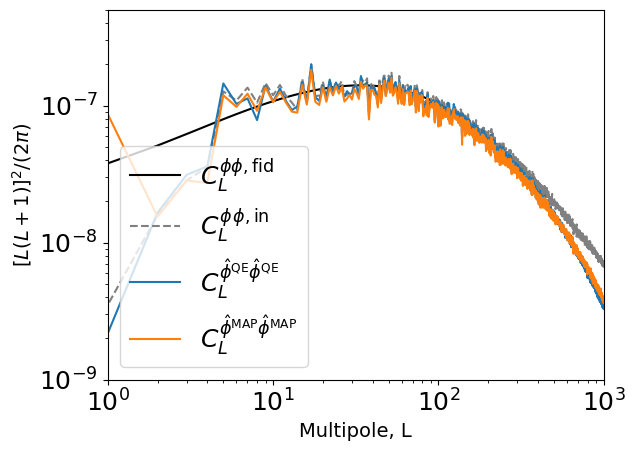

In [17]:
plm_QE = ana_mwe.get_plm_it(0, [0])[0]
plm_MAP = ana_mwe.get_plm_it(0, [ana_mwe.itmax])[0]
plm_in = alm_copy(ana_mwe._sims.get_sim_plm(0), 5120, ana_mwe.qe_lm_max_qlm[0], ana_mwe.qe_lm_max_qlm[1])

ll = np.arange(0,ana_mwe.qe_lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)

plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$', color='black')
plt.plot(scale_factor*hp.alm2cl(plm_in), label=r'$C_L^{\phi^{\rm}\phi,{\rm in}}$', color='grey', ls='--')
plt.plot(scale_factor*hp.alm2cl(plm_QE), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(scale_factor*hp.alm2cl(plm_MAP), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')

plt.legend(fontsize=18, loc='lower left')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,5e-7)
plt.yscale('log')

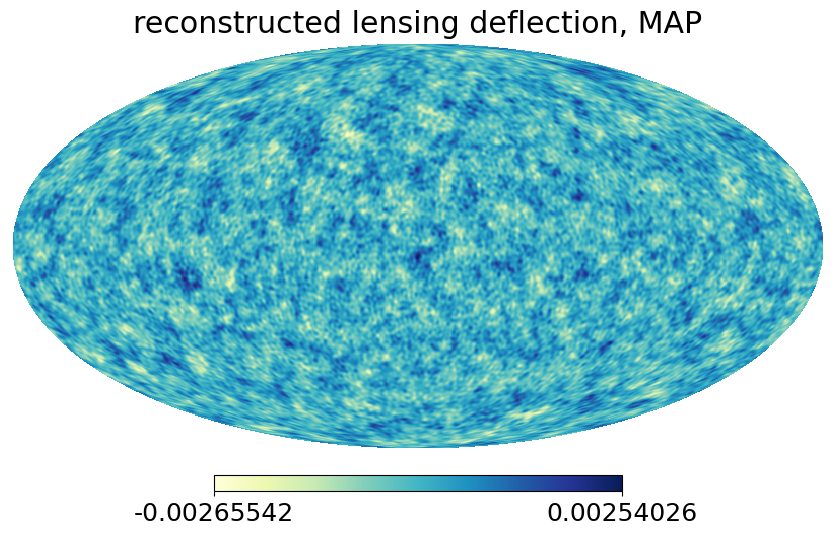

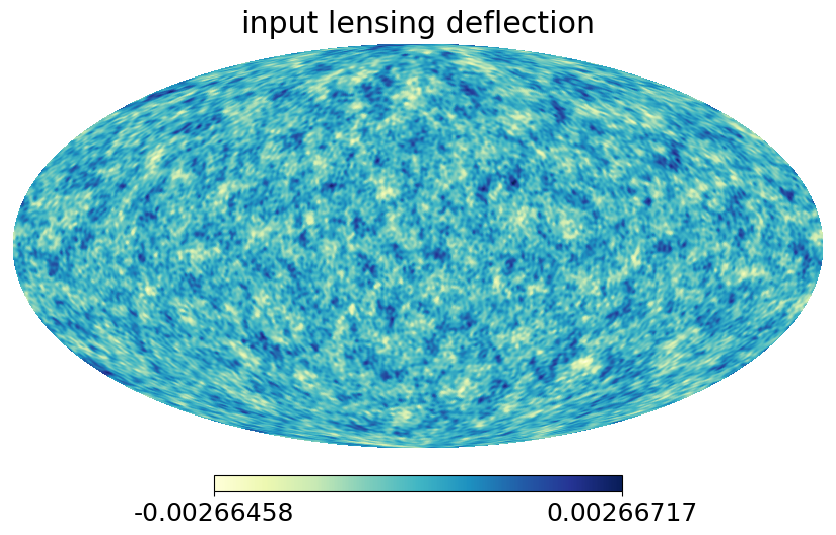

In [ ]:
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(plm_MAP,np.sqrt(ll*(ll+1))),10,200), nside=512), title='reconstructed lensing deflection, MAP', cmap='YlGnBu')
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(ana_mwe._sims.get_sim_plm(0),np.sqrt(ll*(ll+1))),10,200), nside=512), title='input lensing deflection', cmap='YlGnBu')

# Delensed spectrum
For both QE and iterative lensing reconstruction, delensalot already calculated the B-lensing templates. You can use them to delens the B-lensing maps and obtain residual maps

The blue line is the input lensing potential. The QE and MAP estimates are shown in orange and green, and they agree well with the input.

In [18]:
input_blensing = hp.map2alm(hp.alm2map(ana_mwe._sims.get_sim_blm(0), nside=2048), lmax=1024)
blt_QE = ana_mwe.get_blt_it(0, 0)
blt_MAP = ana_mwe.get_blt_it(0, ana_mwe.itmax)

INFO:: 05-12 22:21:: delensalot.core.handler.log - get_blt_it(simidx=0, it=0) started
INFO:: 05-12 22:21:: delensalot.core.handler.log - get_wflm(simidx=0) started
INFO:: 05-12 22:21:: delensalot.core.handler.log - get_wflm(simidx=0) finished
INFO:: 05-12 22:21:: delensalot.core.handler.log - get_plm(simidx=0, sub_mf=False) started
INFO:: 05-12 22:21:: delensalot.core.handler.log - get_plm(simidx=0, sub_mf=False) finished
deflection std is 0.00e+00 amin
deflection: I set numthreads to 2
 DUCC 2 threads deflection instantiated(single prec) 1e-05
INFO:: 05-12 22:21:: delensalot.iterators.iteration_handler.log - get_datmaps() started
INFO:: 05-12 22:21:: delensalot.iterators.iteration_handler.log - get_datmaps() finished
INFO:: 05-12 22:21:: delensalot.iterators.iteration_handler.log - get_filter() started
INFO:: 05-12 22:21:: delensalot.iterators.iteration_handler.log - get_filter() finished
INFO:: 05-12 22:21:: delensalot.iterators.iteration_handler.log - get_iterator() started
INFO:: 0


Total wall clock time for synthesis_general: 18.64s
|
+- getPlane                          : 94.93% (17.6995s)
|  |
|  +- alm2leg                           : 92.29% (16.3345s)
|  +- theta resampling and deconvolution:  4.84% ( 0.8569s)
|  +- phi FFT and dconvolution          :  2.87% ( 0.5075s)
|  +- dealing with borders              :  0.00% ( 0.0006s)
|  
+- interpol (u2nu)                   :  5.07% ( 0.9446s)
+- SphereInterpol setup              :  0.00% ( 0.0000s)
+- build_planes                      :  0.00% ( 0.0000s)
+- setup                             :  0.00% ( 0.0000s)


  build angles <- synthesis (GRAD_ONLY):  [0:00:11.470603] (36.8%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.832429] (2.7%)  
  build_angles                         :  [0:00:12.350334] (39.6%)  
  synthesis general (STANDARD)         :  [0:00:18.693154] (59.9%)  
  polrot (ducc)                        :  [0:00:00.057181] (0.2%)  
  gclm2lenmap                          :  [0:00:31.087927] (99.6%)  
  Total                                :  [0:00:31.204469] d:h:m:s:mus
INFO:: 05-12 22:23:: delensalot.iterators.cs_iterator.log - get_template_blm(it=5) finished
INFO:: 05-12 22:23:: delensalot.core.handler.log - get_blt_it(simidx=0, it=5) finished


In [19]:
blens_residual_QE = input_blensing - blt_QE
blens_residual_MAP = input_blensing - blt_MAP

Text(0, 0.5, '$C_\\ell [\\mu $$\\rm{K}^2$]')

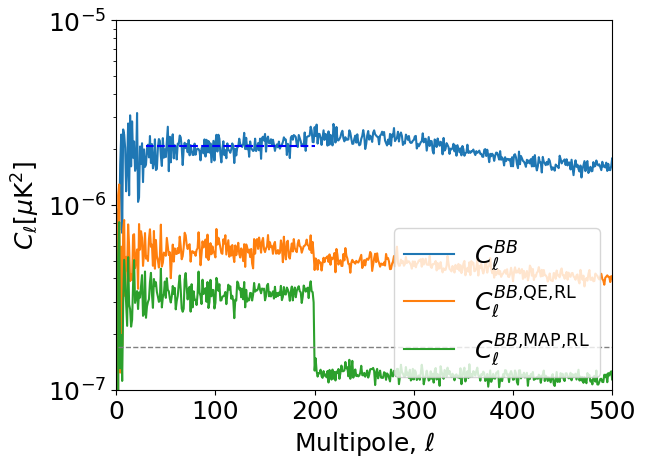

In [20]:
plt.plot(hp.alm2cl(input_blensing, lmax_out=1000), label=r'$C_\ell^{BB}$')
plt.plot(hp.alm2cl(blens_residual_QE, lmax_out=1000), label=r'$C_\ell^{BB{,}{\rm QE{,}RL}}$')
plt.plot(hp.alm2cl(blens_residual_MAP, lmax_out=1000), label=r'$C_\ell^{BB{,}{\rm MAP{,}RL}}$')


plt.hlines(np.mean(hp.alm2cl(input_blensing, lmax_out=210)[30:200]),30,200, color='blue', ls='--')
# plt.hlines(QE_pred*np.mean(hp.alm2cl(input_blensing, lmax_out=210)[30:200]), 30,200, color='orange', ls='--', label='QE prediction')
# plt.hlines(MAP_pred*np.mean(hp.alm2cl(input_blensing, lmax_out=210)[30:200]), 30,200, color='green', ls='--', label='MAP prediction')

plt.hlines((ana_mwe.nlev_p/60/180*np.pi)**2,2,500, color='grey', lw=1,ls='--')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xlim(0,500)
plt.ylim(1e-7,1e-5)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')

## residual lensing amplitude $A_{\rm lens}$
A simple estimate of the reduction of lensing power is to take the ratio between the input and resdiual B-lensing signal, averaged across the scales of interest. Here, we simply take the scales about the recombination peak

In [ ]:
print(20*'~.')
print('nlev_p: {:.3f}, lmax_ivf: {}, beam: {} arcmin '.format(ana_mwe.nlev_p, ana_mwe.lm_max_ivf, ana_mwe._sims.beam))
print('A_{lens}^{QE}\t empiric: '+'{:.3f}\t predicted: {:.3f}'.format(np.mean((hp.alm2cl(blens_residual_QE, lmax_out=200)/hp.alm2cl(input_blensing, lmax_out=200))[30:199]), QE_pred))
print('A_{lens}^{MAP}\t empiric: '+'{:.3f}\t predicted: {:.3f}'.format(np.mean((hp.alm2cl(blens_residual_MAP, lmax_out=200)/hp.alm2cl(input_blensing, lmax_out=200))[30:199]), MAP_pred))
print(20*'~.')

# Normalization and Prediction
To properly compare the estimates to the input data, and to make predictions, we need to normalize the estimates accordingly.
For QE, we calculate the response in the normal manner, for MAP, we calculate the Wiener-Filter inclusive of the noise biases $N^{(0)}_L$, $N^{(1)}_L$, which delensalot can handily predict.

We then use this to make a prediction for $A_L$.

In [14]:
from delensalot.utils_hp import gauss_beam
from plancklens import qresp, utils
from delensalot.lerepi.config.config_helper import data_functions as df
from delensalot.utils import cli
def get_RfidRgrad():
    R_fid = np.array([qresp.get_response(
            self.k,
            self.lm_max_ivf[0],
            self.k[0],
            self.cls_len,
            self.cls_len,
            self.ftebl_len,
            lmax_qlm=self.qe_lm_max_qlm[0],
        )[0] for self in [ana_mwe]])[0]

    cls_lengrad = utils.camb_clfile(opj(os.path.dirname(delensalot.__file__), "data/cls/FFP10_wdipole_gradlensedCls.dat"))
    dl = ana_mwe
    lmax_filter = dl.lm_max_ivf[0]
    transf_tlm = gauss_beam(df.a2r(dl.sims_beam), lmax=lmax_filter) * (np.arange(lmax_filter + 1) >= dl.lmin_teb[0])
    transf_elm = gauss_beam(df.a2r(dl.sims_beam), lmax=lmax_filter) * (np.arange(lmax_filter + 1) >= dl.lmin_teb[1])
    transf_blm = gauss_beam(df.a2r(dl.sims_beam), lmax=lmax_filter) * (np.arange(lmax_filter + 1) >= dl.lmin_teb[2])
    ttebl = {'t': transf_tlm, 'e': transf_elm, 'b':transf_blm}
    ftl_len = cli(cls_lengrad['tt'][:lmax_filter + 1] + df.a2r(ana_mwe.sims_nlev_t)**2 * cli(ttebl['t'] ** 2)) * (ttebl['t'] > 0)
    fel_len = cli(cls_lengrad['ee'][:lmax_filter + 1] + df.a2r(ana_mwe.sims_nlev_p)**2 * cli(ttebl['e'] ** 2)) * (ttebl['e'] > 0)
    fbl_len = cli(cls_lengrad['bb'][:lmax_filter + 1] + df.a2r(ana_mwe.sims_nlev_p)**2 * cli(ttebl['b'] ** 2)) * (ttebl['b'] > 0)
    ftebl_len = {'t': ftl_len, 'e': fel_len, 'b':fbl_len}
    R_grad = np.array([qresp.get_response(
                self.k,
                self.lm_max_ivf[0],
                self.k[0],
                self.cls_len,
                cls_lengrad,
                self.ftebl_len,
                lmax_qlm=self.qe_lm_max_qlm[0],
            )[0] for self in [ana_mwe]])[0]
    return R_fid, R_grad
R_fid, _ = get_RfidRgrad()

In [ ]:
from camb.correlations import lensed_cls
from plancklens import n0s, utils

In [ ]:
from camb.correlations import lensed_cls
from plancklens import n0s, utils

lmin_teb = dict({k:v for k,v in zip(['t', 'e', 'b'], ana_mwe.lmin_teb)})
N0_QE = n0s.get_N0(
    beam_fwhm=ana_mwe._sims.beam,
    nlev_t=ana_mwe.nlev_t,
    nlev_p=ana_mwe.nlev_p,
    lmax_CMB=ana_mwe.lm_max_ivf[0],
    lmin_CMB=lmin_teb,
    )

Cls_del_MAP = n0s.get_N0_iter(
    qe_key='p_p',
    nlev_t=ana_mwe.nlev_t,
    nlev_p=ana_mwe.nlev_p,
    beam_fwhm=ana_mwe._sims.beam,
    cls_unl_fid=ana_mwe.cls_unl,
    lmin_cmb=lmin_teb,
    lmax_cmb=ana_mwe.lm_max_ivf[0],
    itermax=ana_mwe.itmax,
    cls_unl_dat=None,
    lmax_qlm=ana_mwe.qe_lm_max_qlm[0],
    ret_delcls=True)

lmax_qlm = ana_mwe.qe_lm_max_qlm[0]
def cls2dls(cls):
    """Turns cls dict. into camb cl array format"""
    keys = ['tt', 'ee', 'bb', 'te']
    lmax = np.max([len(cl) for cl in cls.values()]) - 1
    dls = np.zeros((lmax + 1, 4), dtype=float)
    refac = np.arange(lmax + 1) * np.arange(1, lmax + 2, dtype=float) / (2. * np.pi)
    for i, k in enumerate(keys):
        cl = cls.get(k, np.zeros(lmax + 1, dtype=float))
        sli = slice(0, min(len(cl), lmax + 1))
        dls[sli, i] = cl[sli] * refac[sli]
    cldd = np.copy(cls.get('pp', None))
    if cldd is not None:
        cldd *= np.arange(len(cldd)) ** 2 * np.arange(1, len(cldd) + 1, dtype=float) ** 2 /  (2. * np.pi)
    return dls, cldd

def dls2cls(dls):
    """Inverse operation to cls2dls"""
    assert dls.shape[1] == 4
    lmax = dls.shape[0] - 1
    cls = {}
    refac = 2. * np.pi * utils.cli( np.arange(lmax + 1) * np.arange(1, lmax + 2, dtype=float))
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k] = dls[:, i] * refac
    return cls

def get_cl_plen(dls_unl_true, cldd_true, N0, N1):
    rho =  np.zeros(len(cldd_true))
    if N1 is None: N1 = np.zeros(len(cldd_true))
    rho[:lmax_qlm + 1] =  cldd_true[:lmax_qlm + 1] * utils.cli(cldd_true[:lmax_qlm + 1] + llp2 * (N0[:lmax_qlm+1] + N1[:lmax_qlm + 1]))
    cpp_del = cldd_true * (1 - rho)
    return dls2cls(lensed_cls(dls_unl_true, cpp_del))['bb']


dls_unl_true, cldd_true = cls2dls(ana_mwe.cls_unl)
llp2 = np.arange(lmax_qlm + 1, dtype=float) ** 2 * np.arange(1, lmax_qlm + 2, dtype=float) ** 2 / (2. * np.pi)
cl_del_QE = get_cl_plen(dls_unl_true, cldd_true, N0_QE[0]['p_p'], np.ones_like(N0_QE[0]['p_p'])*1.8e-9/scale_factor)

QE_pred = np.mean((cl_del_QE[30:200]/ana_mwe.cls_len['bb'][30:200]))
MAP_pred = np.mean((Cls_del_MAP[-1][-1]['bb'][30:200]/ana_mwe.cls_len['bb'][30:200]))

Seeing lmin's:
t: 2
e: 2
b: 200
Seeing lmin's:
t: 2
e: 2
b: 200
 [00:00:17]  ------> 66%


NameError: name 'scale_factor' is not defined

INFO:: 05-12 21:44:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0]) started
INFO:: 05-12 21:44:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0]) finished
INFO:: 05-12 21:44:: delensalot.core.handler.log - get_sim_qlm(simidx=0) started
INFO:: 05-12 21:44:: delensalot.core.handler.log - get_sim_qlm(simidx=0) finished
INFO:: 05-12 21:44:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[5]) started
INFO:: 05-12 21:44:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[5]) finished


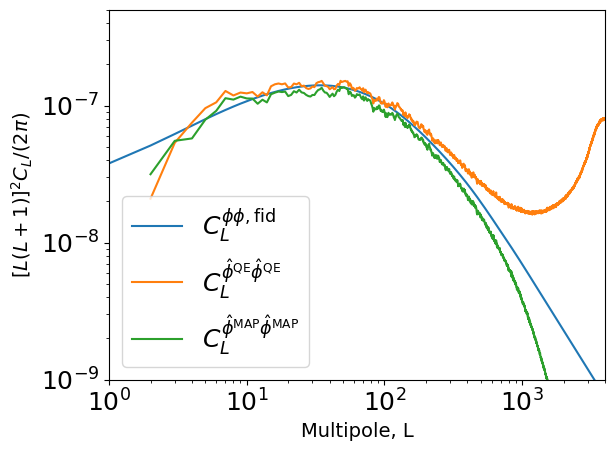

In [16]:
plm_QE = ana_mwe.get_plm_it(0, [0])[0]
qlm_QE = ana_mwe.qe.get_sim_qlm(0)
plm_MAP = ana_mwe.get_plm_it(0, [ana_mwe.itmax])[0]

ll = np.arange(0,ana_mwe.qe_lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)

# ana_mwe.WF_MAP_cpp = (ana_mwe.cpp * utils.cli(ana_mwe.cpp + ana_mwe.N0_MAP + ana_mwe.N1_MAP))[:anas_ng[0].it TBD

plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(movavg(scale_factor*hp.alm2cl(hp.almxfl(qlm_QE,utils.cli(R_fid))), 5), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
# plt.plot(movavg(scale_factor*hp.alm2cl(plm_MAP)/ana_mwe.WF_MAP_cpp, 5), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')
plt.plot(movavg(scale_factor*hp.alm2cl(plm_MAP), 5), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')
# plt.plot(scale_factor*ana_mwe.N0_QE)
# plt.plot(scale_factor*ana_mwe.N0_MAP)
# plt.plot(scale_factor*ana_mwe.N1_QE)
# plt.plot(scale_factor*ana_mwe.N1_MAP)
plt.legend(fontsize=18, loc='lower left')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2C_L/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,4e3)
plt.ylim(1e-9,5e-7)
plt.yscale('log')

## Plot
 * residual lensing amplitude $A_{\rm lens}$
 
A simple estimate of the reduction of lensing power is to take the ratio between the input and resdiual B-lensing signal, averaged across the scales of interest. Here, we simply take the scales about the recombination peak

# Summary and next steps
This tutorial demonstrated the usage of delensalot in an idealized setting, and you obtained lensing potential estimates and residual lensing amplitudes from simulation data generated upon runtime.

delensalot can also perfrom lensing reconstruction on more challenging settings such as,

 * masked sky,
 * inhomogeneous noise,
 * data inclusive of foreground (residuals).
 

It also has MPI support.
 
Please check out the other tutorials, or see the [documentation](link_to_rtd_doc), or [github](https://github.com/NextGenCMB/delensalot) for more.